公众号：进击的MsCat

In [0]:
from fastai import *
from fastai.text import *

In [0]:
path = untar_data(URLs.IMDB_SAMPLE)
path.ls()

[PosixPath('/root/.fastai/data/imdb_sample/texts.csv')]

is_valid标记该条数据是训练集还是验证集，如果is_valid是True，则该条数据是验证集

In [0]:
df = pd.read_csv(path/'texts.csv')
df.head()

,label,text,is_valid
0,negative,Un-bleeping-believable! Meg Ryan doesn't even ...,False
1,positive,This is a extremely well-made film. The acting...,False
2,negative,Every once in a long while a movie will come a...,False
3,positive,Name just says it all. I watched this movie wi...,False
4,negative,This movie succeeds at being one of the most u...,False


TextDataBunch是DataBunch的子类，from_csv从csv中读取数据，构建TextDataBunch对象。
在TextDataBunch里对数据进行“分词Tokenization”和“数字化Numericalization”，Tokenization需要注意空格、连写词、标点，并且去掉可能有的html代码，从而将整句分割为标识符token。

In [0]:
data_lm = TextDataBunch.from_csv(path,'texts.csv')
data_lm.show_batch()

text,target
"xxbos xxmaj now that xxmaj che(2008 ) has finished its relatively short xxmaj australian cinema run ( extremely limited xxunk screen in xxmaj sydney , after xxunk ) , i can xxunk join both xxunk of "" xxmaj at xxmaj the xxmaj movies "" in taking xxmaj steven xxmaj soderbergh to task . \n \n xxmaj it 's usually satisfying to watch a film director change his style /",negative
"xxbos xxmaj this film sat on my xxmaj tivo for weeks before i watched it . i dreaded a self - indulgent xxunk flick about relationships gone bad . i was wrong ; this was an xxunk xxunk into the screwed - up xxunk of xxmaj new xxmaj yorkers . \n \n xxmaj the format is the same as xxmaj max xxmaj xxunk ' "" xxmaj la xxmaj ronde",positive
"xxbos i really wanted to love this show . i truly , honestly did . \n \n xxmaj for the first time , gay viewers get their own version of the "" xxmaj the xxmaj bachelor "" . xxmaj with the help of his obligatory "" hag "" xxmaj xxunk , xxmaj james , a good looking , well - to - do thirty - something has the chance",negative
"xxbos \n \n i 'm sure things did n't exactly go the same way in the real life of xxmaj homer xxmaj hickam as they did in the film adaptation of his book , xxmaj rocket xxmaj boys , but the movie "" xxmaj october xxmaj sky "" ( an xxunk of the book 's title ) is good enough to stand alone . i have not read xxmaj",positive
"xxbos xxmaj to review this movie , i without any doubt would have to quote that memorable scene in xxmaj tarantino 's "" xxmaj pulp xxmaj fiction "" ( xxunk ) when xxmaj jules and xxmaj vincent are talking about xxmaj mia xxmaj wallace and what she does for a living . xxmaj jules tells xxmaj vincent that the "" xxmaj only thing she did worthwhile was pilot "" .",negative


保存data_lm databunch到当前目录下，下次重新进入notebook直接load即可获得数据


In [0]:
data_lm.save()

**加载模型：**
在最新版本的fastai库环境下，执行下面这个语句会报错：FileNotFoundError: [Errno 2] No such file or directory: '/root/.fastai/data/imdb_sample/tmp/itos.pkl'
因为最新的fastai库去掉了TextDataBunch的load方法（仅在v1.0.43及之前可用），替代的加载DataBunch方法为load_data(path)


In [0]:
#此句会报错
#dataload = TextDataBunch.load(path)

In [0]:
#替代方案
dataload = load_data(path)

使用DataBunch类的show_batch()方法查看数据集的大致格式与内容。默认show_batch()显示数据集的列标签和前5行

In [0]:
dataload.show_batch()

text,target
"xxbos xxmaj now that xxmaj che(2008 ) has finished its relatively short xxmaj australian cinema run ( extremely limited xxunk screen in xxmaj sydney , after xxunk ) , i can xxunk join both xxunk of "" xxmaj at xxmaj the xxmaj movies "" in taking xxmaj steven xxmaj soderbergh to task . \n \n xxmaj it 's usually satisfying to watch a film director change his style /",negative
"xxbos xxmaj this film sat on my xxmaj tivo for weeks before i watched it . i dreaded a self - indulgent xxunk flick about relationships gone bad . i was wrong ; this was an xxunk xxunk into the screwed - up xxunk of xxmaj new xxmaj yorkers . \n \n xxmaj the format is the same as xxmaj max xxmaj xxunk ' "" xxmaj la xxmaj ronde",positive
"xxbos i really wanted to love this show . i truly , honestly did . \n \n xxmaj for the first time , gay viewers get their own version of the "" xxmaj the xxmaj bachelor "" . xxmaj with the help of his obligatory "" hag "" xxmaj xxunk , xxmaj james , a good looking , well - to - do thirty - something has the chance",negative
"xxbos \n \n i 'm sure things did n't exactly go the same way in the real life of xxmaj homer xxmaj hickam as they did in the film adaptation of his book , xxmaj rocket xxmaj boys , but the movie "" xxmaj october xxmaj sky "" ( an xxunk of the book 's title ) is good enough to stand alone . i have not read xxmaj",positive
"xxbos xxmaj to review this movie , i without any doubt would have to quote that memorable scene in xxmaj tarantino 's "" xxmaj pulp xxmaj fiction "" ( xxunk ) when xxmaj jules and xxmaj vincent are talking about xxmaj mia xxmaj wallace and what she does for a living . xxmaj jules tells xxmaj vincent that the "" xxmaj only thing she did worthwhile was pilot "" .",negative


**数字化Numericalization**
NumericalizeProcessor将token数字化，
x.vocab返回类型为fastai.text.transform.Vocab，Vocab类可进行token和id之间的转化。itos将id转化为token,返回list

In [0]:
#dataload.volab.itos[:10]
x = NumericalizeProcessor(dataload)
x.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the']

查看分词后的文本,train_ds是fastai.data_block.LabelList类型
在这个例子中x是TextList，y是CategoryList

In [0]:
dataload.train_ds[0][0]

Text xxbos xxmaj having enjoyed xxmaj jean xxmaj arthur in " xxmaj the xxmaj devil and xxmaj miss xxmaj jones " , my interest was peaked , so i tried sitting through this second - string screwball outing about an xxunk into the death of a xxunk -- but i did n't make it to the end . xxmaj arthur , photographed in a xxunk , movie - magazine fashion , either wants xxunk from ex - husband xxmaj william xxmaj powell or another shot at marriage , but i never felt for her because the character is just a string of xxunk ( she 's the type of heroine prone to comical xxunk , but once inside a morgue -- like all women in these ' 30 's comedies -- she xxunk ) . xxmaj william xxmaj powell xxunk had a high time working with xxmaj miss xxmaj arthur , but you 'd never know it from the end result ; they look awkward standing next to each other , xxunk over their banter . xxmaj the actor playing xxmaj powell 's xxunk is excruciating , and the xxunk for viewer laughs are pregnant with xxunk .

In [0]:
dataload.train_ds

LabelList (799 items)
x: TextList
xxbos xxmaj having enjoyed xxmaj jean xxmaj arthur in " xxmaj the xxmaj devil and xxmaj miss xxmaj jones " , my interest was peaked , so i tried sitting through this second - string screwball outing about an xxunk into the death of a xxunk -- but i did n't make it to the end . xxmaj arthur , photographed in a xxunk , movie - magazine fashion , either wants xxunk from ex - husband xxmaj william xxmaj powell or another shot at marriage , but i never felt for her because the character is just a string of xxunk ( she 's the type of heroine prone to comical xxunk , but once inside a morgue -- like all women in these ' 30 's comedies -- she xxunk ) . xxmaj william xxmaj powell xxunk had a high time working with xxmaj miss xxmaj arthur , but you 'd never know it from the end result ; they look awkward standing next to each other , xxunk over their banter . xxmaj the actor playing xxmaj powell 's xxunk is excruciating , and the xxunk for viewer laughs are preg

dataload.train_ds[0][0]是fastai.text.data.Text类型，data返回数字化的表示

In [0]:
dataload.train_ds[0][0].data[:10]

array([   2,    5,  269,  621,    5, 2010,    5, 1029,   18,   22])

使用data block API创建databunch，因为数据源来自csv文件，因此用from_csv方法。

1.   如何划分测试集和验证集？
 **split_from_df(col=2)**根据第三列（is_valid）的布尔值来区分训练集和验证集：is_valid[index]为正，数据被放入验证集，is_valid[index]为负放入训练集
2.   如何给数据加标签？**label_from_df()**方法仅能在通过“from_csv”或“from_df”创建的data对象上使用，给数据加标签值（从第一列获取标签）
3. 没有add_test_foler()，因此不创建测试集

4. databunch():默认参数创建TextDataBunch





In [0]:
data = (TextList.from_csv(path,'texts.csv',cols='text').split_from_df(col=2).label_from_df(cols=0).databunch())

上面通过“分词Tokenization”和“数字化Numericalization”。处理了IMDB数据的一个小样本，并创建了TextDataBunch，下面以Wikitext103预训练模型为基础，通过整个IMDB数据集微调模型。

## 1、建立IMDB语言模型

### （1）IMDB数据集下载及预处理

In [0]:
path = untar_data(URLs.IMDB)
path.ls()

[PosixPath('/root/.fastai/data/imdb/unsup'),
 PosixPath('/root/.fastai/data/imdb/imdb.vocab'),
 PosixPath('/root/.fastai/data/imdb/tmp_lm'),
 PosixPath('/root/.fastai/data/imdb/test'),
 PosixPath('/root/.fastai/data/imdb/README'),
 PosixPath('/root/.fastai/data/imdb/tmp_clas'),
 PosixPath('/root/.fastai/data/imdb/train')]



1.   bs是batch size（批大小）
2.   from_folder()表明Input是文件夹里所有的文本文件
3.   filter_by_folder(include=['train','test'])
表示仅仅保留'train'和'test'里的文件，进一步确定数据源
4. Jeremy课程中提到的random_split_by_pct()方法被优化掉了，改成split_by_rand_pct(valid_pct)，随机划分训练集和验证集，验证集中样本数占所有样本数的比率为valid_pct，默认比率为20%
5. label_for_lm()指在语言模型上特定的设置标签的方法。因为训练属于自监督学习，标签来自数据自身，而非人工设定。
---


其他：
创建data_lm要花一点时间，因为要进行文本分词和数字化。
现在用data_lm.save('tmp_lm')会报"找不到tmp_lm文件夹"的错，可改成data_lm.save('tmp_lm.pkl')，也可用
data_lm.save()，但是这样会跟其他默认保存的databunch混淆。

In [0]:
bs = 48
data_lm = (TextList.from_folder(path)
      .filter_by_folder(include=['train','test'])
      .split_by_rand_pct(0.1)
      .label_for_lm()
      .databunch(bs=bs))


In [0]:
data_lm.vocab

In [0]:
data_lm.save('tmp_lm.pkl')

加载databunch，数据集中所有的文本都用来训练，标签都被忽略。
data_lm是TextLMDataBunch类，适于训练语言模型。
TextLMDataBunch.load(path, 'tmp_lm', bs=bs)方在新的fastai库中被优化掉了，加载databunch数据可以用load_data()

In [0]:
data_lm = load_data(path,'tmp_lm.pkl',bs = bs)
data_lm.show_batch()

idx,text
0,""" was the house from xxmaj fantasy xxmaj island ( and a million other movies and xxup tv shows ; the place is located in the xxup l.a. area ) . i fully expected xxmaj mr xxmaj roarke and xxmaj tattoo to come out and greet the visitors . xxmaj if xxmaj tattoo had gotten eaten by the snake , i might have given this movie a 2 , but"
1,"xxmaj club "" all over again , but i was mistaken ) . xxmaj too bad . "" xxmaj nature of the xxmaj beast "" could have been something else ... instead of nothing else . xxbos xxmaj this is one of the most boring films i 've ever seen . xxmaj the three main cast members just did n't seem to click well . xxmaj giovanni xxmaj ribisi 's"
2,"n't believe exists , with dialog , plotting , and direction so ineptly handled that xxmaj uncle xxmaj ned 's xxmaj xxunk xxmaj cavern home video looks like an xxup imax experience . xxmaj since it 's a xxmaj troma flick , there 's plenty of gross - out gore on tap , but its even sillier than usual . \n \n xxmaj most of the production money seems"
3,". \n \n xxmaj the scripting is awful , just awful , with no characterisation at all . xxmaj the performances suffer as a result , you can see the likes of xxmaj hardwicke and xxmaj andrews writhing in an agony of embarrassment as they deliver the most ridiculous shallow trite codswallop lines . xxmaj the writers seem to feel the need to explain almost everything in a dreadful"
4,"& xxmaj ric xxmaj gibbs , are pedestrian as they come , not much differing from other xxmaj white xxmaj house conspiracy thrillers as in xxup absolute xxup power and xxup murder xxup at 1600 . xxmaj some considerable talents ( xxmaj donald xxmaj sutherland , xxmaj ben xxmaj gazzara and xxmaj stephen xxmaj lang ) try their best on a routine script , but rarely saves it from predictability"


### （2）创建影评语言模型学习器（language_model_learner）并训练
创建一个学习器language_model_learner,底层神经网络是RNN循环神经网络。


1.   data_lm为存储IMDB语言模型的databunch
2.   pretrained_model=URLs.WT103指要用到的预处理模型，fastai在执行语句的过程中会把这个模型下载下来。
3.   drop_mult=0.3设置神经元dropput（随机失活）的比率，正则化项用来防止过拟合，减少正则化参数可以防止模型出现欠拟合。dropout的设置也是用来防止过拟合，dropout比例减小也会防止模型出现欠拟合。


---


创建语言模型时候用pretrained_model=URLs.WT103会报错：“AttributeError: type object 'URLs' has no attribute 'WT103'”
在这里改成“arch=AWD_LSTM”。
参见文档：[Fine-tuning-a-language-model](https://docs.fast.ai/text.html#Fine-tuning-a-language-model)


In [0]:
learn = language_model_learner(data_lm,arch = AWD_LSTM, drop_mult=0.3)

创建学习器后可用lr_find()找最好的学习率区间,lr_find()是learner类的一个方法,（原型：lr_find(learn:Learner, start_lr:Floats=1e-07, end_lr:Floats=10, num_it:int=100, stop_div:bool=True, wd:float=None)）学习器会模拟训练默认100次，找到最优的学习率。

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


绘制loss随着learningrate改变的图像，寻找loss最快下降的区间
。learn.recorder.plot(self, skip_start:int=10, skip_end:int=5, suggestion:bool=False, return_fig:bool=None,**kwargs)->Optional[plt.Figure][skip_start，skip_end]表示绘图时lr与loss数组的取值区间。当skip_end>0时函数中取loss[skip_start,-skip_end]和lr[skip_start,-skip_end]来绘图，当skip_end<0时函数中取loss[skip_start:]和lr[skip_start:]。
调整skip_end参数可以比较结果，skip_start取默认值，skip_end越小时绘制点越少，函数图像就显得更平滑。

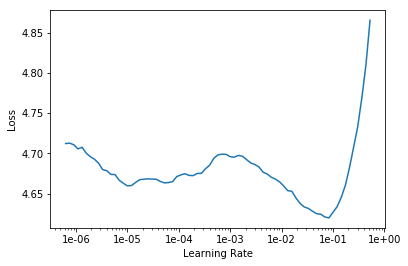

In [0]:
learn.recorder.plot(skip_end=15)

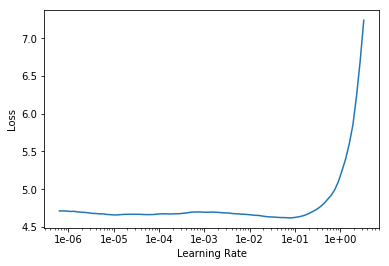

In [0]:
#测试
learn.recorder.plot(skip_end=5)

fit_one_cycle(1,1e-2,moms=(0.8,0.7))1表示更新模型时的迭代次数（1个epoch），1e-2为最大学习率，moms为动量。这里只“微调”了模型的最后几层全连接层，前面的模型权重是“frozen”状态。


In [0]:
learn.fit_one_cycle(1,1e-2,moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.159715,4.004369,0.295362,41:05


unfreeze()使得所有层的权重都可被更新。进行更多次训练（3个epoch）。Jeremy在课程中用的10个epoch，时间会比较长。

In [0]:
learn.unfreeze()
learn.fit_one_cycle(3, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.854703,3.835063,0.314388,46:16
1,3.713718,3.735543,0.327164,46:20
2,3.553257,3.704727,0.331461,46:21


准确率超过0.3效果说明语言模型已经训练得比较好了。

## 2、用影评语言模型做预测

给一个句子的前半部分，这个语言模型会把它补全。predict()将单词根据概率分布随机取出，temperature默认值是1，降低temperature值会降低文本随机性。min_p设置了输出单词时考虑的概率最小值。

In [0]:
learn.predict('I like this movie because',100,temperature=1.1,min_p=0.001)

'I like this movie because it \'s about the perfect old fashioned book of the cinema , that could have been a lot more engaging . It will make a lot of sense without getting older and at last . Do n\'t miss this one . \n \n  When the " first French class kid " spoke to everyone , i did n\'t think at the time . \n \n  i will give credit to their writers for changing the plot into the movie to fill it up , and to create the story \'s point of view . What made it'

后续影评情绪分类可以把影评语言模型作为预训练模型，因此我们保存这个模型的encoder部分。之所以不全部保存，是因为模型的后半部分是用来预测句子中下一个单词的，对理解影评语句没有用处。模型中有关理解语句的部分被称为“encoder”，因此用save_encoder()函数只保存encoder部分。

In [0]:
learn.save_encoder('fine_tuned_enc')

## 3、建立影评情绪分类器

### （1）创建一个DataBunch并保存


1.vocab=data_lm.vocab：   
之前我们读取了train、text文件夹中的所有文本数据创建影评数据集databunch，并用来创建了languagemodel。在创建分类器时，我们要用之前languagemodel的encoder作为预训练模型，因此创建分类器时要用同一套分词和数字化的规则。如果在语言模型中10表示‘the’，在分类器中10也一定要表示‘the’，否则预训练模型的输出就没有了意义。

2.split_by_folder(valid='test')根据文件夹划分训练集和验证集。因为path目录下只有train文件夹和test文件夹，就不用.filter_by_folder(include=['train', 'test'])了。

3.label_from_folder(classes=['neg', 'pos'])
用'neg','pos'给数据加标签。

4.filter_missing_y()如果发现有文本label不是neg或者pos，会将文本删除

5.如果在训练过程中发现GPU资源用完，可以将bs值降低。

直接运行课程中的代码会报错：'bool' object is not callable
保存databunch的时候记得加pkl文件后缀，否则会报错。


In [0]:
textlist = TextList.from_folder(path, vocab=data_lm.vocab)
textlist_byfolder = textlist.split_by_folder(valid='test')
testlist_byfolder_label = textlist_byfolder.label_from_folder(classes=['neg','pos'])#train,test文件夹下有neg文件夹和pos文件夹
# data_clas_folder = (TextList.from_folder(path, vocab=data_lm.vocab)
#              #grab all the text files in path
#              .split_by_folder(valid='test')
#              #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
#              .label_from_folder(classes=['neg', 'pos'])
#              #remove docs with labels not in above list (i.e. 'unsup')
testlist_byfolder_label.filter_missing_y = True
data_clas = testlist_byfolder_label.databunch(bs=bs)
             #label them all with their folders
data_clas.save('tmp_clas.pkl')

### （2）加载DataBunch

path为存储位置，‘tmp’为dataBunch存储名称，bs为batchsize。在创建dataBunch时传递的参数比如（bs=50）没有保存，因此需要在加载的时候重新传入参数，否则对应参数会使用默认值。
此处用load_data()函数来加载。

In [0]:
data_clas=load_data(path,'tmp_clas.pkl',bs=bs)
data_clas.show_batch()

text,target
xxbos xxmaj match 1 : xxmaj tag xxmaj team xxmaj table xxmaj match xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley vs xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley started things off with a xxmaj tag xxmaj team xxmaj table xxmaj match against xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit . xxmaj according to the rules,pos
"xxbos xxmaj by now you 've probably heard a bit about the new xxmaj disney dub of xxmaj miyazaki 's classic film , xxmaj laputa : xxmaj castle xxmaj in xxmaj the xxmaj sky . xxmaj during late summer of 1998 , xxmaj disney released "" xxmaj kiki 's xxmaj delivery xxmaj service "" on video which included a preview of the xxmaj laputa dub saying it was due out",pos
"xxbos xxmaj some have praised _ xxunk _ as a xxmaj disney adventure for adults . i do n't think so -- at least not for thinking adults . \n \n xxmaj this script suggests a beginning as a live - action movie , that struck someone as the type of crap you can not sell to adults anymore . xxmaj the "" crack staff "" of many older",neg
"xxbos xxmaj waitress : xxmaj honey , here 's them eggs you ordered . xxmaj honey , like bee , get it ? xxmaj that 's called pointless foreshadowing . \n \n xxmaj edward xxmaj basket : xxmaj huh ? ( xxmaj on the road ) xxmaj basket : xxmaj here 's your doll back , little girl . xxmaj you really should n't be so careless with your",neg
"xxbos xxmaj the vigilante has long held a fascination for audiences , inasmuch as it evokes a sense of swift , sure justice ; good triumphs over evil and the bad guy gets his deserts . xxmaj it is , in fact , one of the things that has made the character of xxmaj dirty xxmaj harry xxmaj callahan ( as played by xxmaj clint xxmaj eastwood ) so popular",pos


### （3）创建text_classifier_learner分类器并训练




1.   text_classifier_learner()创建分类器，传入data_clas，如果过拟合提高drop_mult的值，如果欠拟合降低drop_mult的值。fastai库更新后，需要传arch参数，可设置为AWD_LSTM，会自动从URLs.WT103_1中加载预训练权重。 
2.   加载语言模型的encoder
3.learn.freeze()将除最后一组层外的所有层都设置为‘untrainable’，即训练时不更新权重。


In [0]:
learn=text_classifier_learner(data_clas,arch=AWD_LSTM,drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')
learn.freeze()#learn是一个RNNLearner


 

4.   lr_find()并绘图找到最佳学习率
5.   先训练最后一组层
语言模型训练起来可能要花费比较长的时间，但是某一领域只需要做一个语言模型并保存，就能在语言模型的基础上很快训练出很好的分类器或其

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,accuracy,time
0,0.283202,0.217805,0.914720,10:13


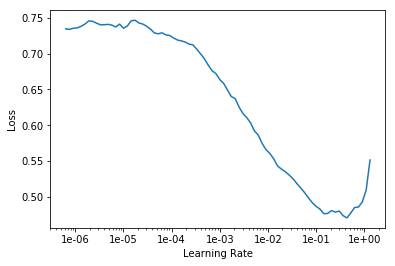

In [0]:
learn.lr_find()
learn.recorder.plot()
learn.fit_one_cycle(1,2e-2,moms=(0.8,0.7))
learn.save('first')



6.   unfreeze让更多层参与训练。这里用freezeto(-2)仅“解冻”最后两层。在文本分类上每次只“解冻”一层比解冻之前的所有层效果要好。
7.   做一次训练。为什么这里的最小学习率要是1e-3除以2.6的四次方？max_lr参数设置为slice使得模型每一组层的学习速率不同，这种设置被称为“discriminative learning rates”。Jeremy用随机森林来预测超参对文本分类器准确度的影响，发现后一组层的学习率最好是前一组层的2.6倍。


In [0]:
learn.load('first')
learn.freeze_to(-2)
learn.fit_one_cycle(1,slice(1e-2/(2.6**4),1e-2),moms=(0.8,0.7))
learn.save('second')

epoch,train_loss,valid_loss,accuracy,time
0,0.249769,0.181265,0.931040,12:57


In [0]:
learn.summary()
learn.model

SequentialRNN(
  (0): MultiBatchEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(49816, 400, padding_idx=1)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(49816, 400, padding_idx=1)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1152, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1152, 1152, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1152, 400, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0): RNNDropout()
        (1): RNNDropout()
        (2): RNNDropout()
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.2, inplace=False)
      (2): Linear(in_features=1200, out_features=50, bias=True)
      (3): ReLU(inplace=True)
      (4): BatchNorm1d(50, 


8.   第二次训练结果准确率已经达到了0.93，比第一次有所提高，再往前unfreeze一层并进行训练(准确率0.94)。


In [0]:
learn.load('second')
learn.freeze_to(-3)
learn.fit_one_cycle(1,slice(5e-3/(2.6**4),5e-3),moms=(0.8,0.7))
learn.save('third')

epoch,train_loss,valid_loss,accuracy,time
0,0.203254,0.152514,0.942960,15:56


In [0]:
learn.summary()

SequentialRNN
Layer (type)         Output Shape         Param #    Trainable 
RNNDropout           [61, 400]            0          False     
______________________________________________________________________
RNNDropout           [61, 1152]           0          False     
______________________________________________________________________
RNNDropout           [61, 1152]           0          False     
______________________________________________________________________
BatchNorm1d          [1200]               2,400      True      
______________________________________________________________________
Dropout              [1200]               0          False     
______________________________________________________________________
Linear               [50]                 60,050     True      
______________________________________________________________________
ReLU                 [50]                 0          False     
________________________________________________



9.   unfreeze所有层并训练(训练RNN网络时，稍微降低momentum值有利于训练）



In [0]:
learn.load('third')
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.173503,0.150027,0.942920,21:10
1,0.160777,0.149272,0.943760,19:12


In [0]:
learn.save('final')